In [12]:
import os, json
from Tint_Matlab import *
import struct
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import SignalProcessing as sp
%matplotlib inline

In [2]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""
    
    
    if channels == []:
        channels = np.arange(64)+1
    else:
        channels = np.asarray(channels)
    
    A = np.asarray(A)
    
    sample_num = int(len(A)/64) # get the sample numbers
    
    sample_array = np.zeros((len(channels),sample_num)) # creating a 64x3 array of zeros (64 channels, 3 samples)
    
    '''
    for i in range(3):
        # there are three samples
        
        current_sample = A[:64] # defines current samples
        
        for k in range(64):
            
            sample_array[k,i] = current_sample[get_remap_chan(k+1)]
        
        A = A[64:]  # discards the used samples
    '''
    
    for i, channel in enumerate(channels):
        sample_array[i,:] = A[get_sample_indices(channel, sample_num)]
            
    return sample_array

def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)
    

def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""
    
    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 
                      6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11, 
                      12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17, 
                      18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63, 
                      24, 25, 26, 27, 28, 29, 30, 31])
    
    return remap_channels[chan_num-1]
            
            
def find_sub(string, sub):
    '''finds all instances of a substring within a string and outputs a list of indices'''
    result = []
    k = 0
    while k < len(string):
        k = string.find(sub, k)
        if k == -1:
            return result
        else:
            result.append(k)
            k += 1  # change to k += len(sub) to not search overlapping results
    return result


def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if 
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'
    
    with open(set_filename) as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_')+1:])
                    active_tetrode.append(tet_number)
                    
    return active_tetrode

def get_active_eeg(set_filename):
    """This will return a dictionary (cative_eeg_dict) where the keys 
    will be eeg channels from 1->64 which will represent the eeg suffixes (2 = .eeg2, 3 = 2.eeg3, etc)
    and the key will be the channel that the EEG maps to (a channel from 0->63)"""
    active_eeg = []
    active_eeg_str = 'saveEEG_ch'
    
    eeg_map = []
    eeg_map_str = 'EEG_ch_'
    
    active_eeg_dict = {}
    
    with open(set_filename) as f:
        for line in f:
            
            if active_eeg_str in line:
                 # saveEEG_ch_X Y, where x is the eeg number, and Y is eitehr on or off (1 or 0)
                _, status = line.split(' ')
                active_eeg.append(int(status))
            elif eeg_map_str in line:
                #EEG_ch_X Y
                _, chan = line.split(' ')
                eeg_map.append(int(chan))
                
                
        # active_eeg = np.asarray(active_eeg)
        # eeg_map = np.asarray(eeg_map)
    
    for i, status in enumerate(active_eeg):
        if status == 1:
            active_eeg_dict[i+1] = eeg_map[i] - 1
        
    return active_eeg_dict


def is_egf_active(set_filename):
    
    active_egf_str = 'saveEGF'
    
    with open(set_filename) as f:
        for line in f:
            
            if active_egf_str in line:
                _, egf_status = line.split(' ')
                
                if int(egf_status) == 1:
                    return True
                
        return False

    
def get_Fs(set_filename):
    
    fs_str = 'rawRate'
    
    with open(set_filename) as f:
        for line in f:
            
            if fs_str in line:
                _, Fs = line.split(' ')
                
                try:
                    return int(Fs)
                except:
                    return float(Fs)
    return []
   
    
def create_eeg(filename, data, Fs):
    # data is given in int16, and already has been notch filtered
    
    if os.path.exists(filename):
        return
    
    Fs_EEG = 250  # sampling rate of .EEG files
    
    data = sp.Filtering().iirfilt(bandtype='low', data=data, Fs=Fs, Wp=Fs_EEG / 2, order=6, 
                                  automatic=0, Rp=3, As=60, filttype='butter', showresponse=0)
    
    ##################################################################################################
    # ---------------------------Downsample to produce the proper EEG------------------------
    ##################################################################################################
    
    data = data[:, 0::int(Fs / Fs_EEG)]
    
    # ensuring the appropriate range of the values
    data[np.where(data > 32767)] = 32767
    data[np.where(data < -32768)] = -32768
    
    data = int16toint8(data) # converting from 16 bits to 8 bits, 
    
    # ensurinig appropriate range of values (this shouldn't be necessary)
    data[np.where(data > 127)] = 127
    data[np.data(data < -128)] = -128
    
    ##################################################################################################
    # ---------------------------Writing the EEG Data-------------------------------------------
    ##################################################################################################
    
    write_eeg(filename, data, Fs_EEG)
    
def create_egf(filename, data, Fs):
    
    if os.path.exists(filename):
        return
    
    Fs_EGF = 4.8e3  # sampling rate of .EGF files
    
    data = sp.Filtering().iirfilt(bandtype='low', data=data, Fs=Fs, Wp=Fs_EGF / 2, order=6, 
                                  automatic=0, Rp=3, As=60, filttype='butter', showresponse=0)
    
    ##################################################################################################
    # ---------------------------Downsample to produce the proper EGF Data------------------------
    ##################################################################################################
    
    data = data[:, 0::int(Fs / Fs_EGF)]
    
    # ensuring the appropriate range of the values
    data[np.where(data > 32767)] = 32767
    data[np.where(data < -32768)] = -32768
    
    # data is already in int16 which is what the final unit should be in
    
    ##################################################################################################
    # ---------------------------Writing the EGF Data-------------------------------------------
    ##################################################################################################
    
    write_eeg(filename, data, Fs_EGF)
    

In [3]:
def int16toint8(value):
    """Converts int16 data to int8"""
    return np.rint(np.divide(value, 256))
    

def get_set_header(set_filename):
    
    with open(set_filename, 'r+') as f:
        header = ''
        for line in f:
            header += line
            if 'sw_version' in line:
                break
    return header

            

In [4]:
def overwrite_setfile(set_filename):
    
    with open(set_filename, 'r+') as f:
        
        header = ''
        footer = ''
        
        header_values = True
        
        for line in f:
            
            if header_values:
                if 'duration' in line:
                    print(list(line))
                    duration = int(np.ceil(float(line.split(' ')[-1])))
                    header += 'duration %d\n' % duration
                    continue
                header += line
                
            else:
                footer += line
                
    
    with open(set_filename, 'w') as f:
        
        f.writelines([header, footer])


In [5]:
#bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
# bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
#bin_filename = "C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"
bin_filename = "C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"

bin_directory = os.path.dirname(bin_filename)
session = os.path.basename(os.path.splitext(bin_filename)[0])
set_filename = os.path.join(bin_directory, '%s.set' % session)
pos_filename = os.path.join(bin_directory, '%s.pos' % session)

# Determining How Many Samples Are Recorded

In [6]:
#Fs = 48000
#duration = iteration_count * 3 / Fs
#print(duration)

In [11]:
#Determining How Many Samples Are Recorded
byte_count = os.path.getsize(bin_filename)
bytes_per_iteration = 432
iteration_count = int(byte_count/bytes_per_iteration)  
sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
Fs = 48000
duration = iteration_count * 3 / Fs
print(byte_count, iteration_count)

414763200 960100


# Reading Position Data

In [22]:
a = np.array([[1,2,3], [4,5,6]])
print(a)
print(a[:, [1,2,0]])

[[1 2 3]
 [4 5 6]]
[[2 3 1]
 [5 6 4]]


In [6]:
def get_raw_pos(bin_filename):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
    
    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent
    
    The .bin file is written of packets of 432 bytes containing position data, three samples of 
    electrophys data (per channel), and etc.
    
    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    """
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    byte_skip = data_byte_len +  trailer_byte_len # 384 ephys data bytes + 16 trailer bytes
    
    pos_Fs = 50
    n_samples = int(duration*pos_Fs)
    
    raw_pos = np.array([])
    
    with open(bin_filename, 'rb') as f:
        
        for i in range(iteration_count):
            byte_id = f.read(4)

            if 'ADU2' in str(byte_id):
                f.seek(8, 1)  # moves the current position by 10 bytes
                position_data = f.read(20)
                
                time_data = position_data[:4]
                time_data = np.asarray(struct.unpack('i', time_data))
                time_data = time_data / 50
                
                # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
                position_data = np.hstack((i, time_data, np.asarray(struct.unpack('8h', position_data[4:]))))
                
                if len(raw_pos) != 0:
                    raw_pos = np.vstack((raw_pos, position_data))
                else:
                    raw_pos = position_data
                
                f.seek(byte_skip, 1)
                
                #pos_sample_num += 1
                
            else:
                f.seek(bytes_per_iteration-4, 1)
            '''    
            if pos_sample_num > 50:
                break
            '''
        # the X and Y values are reverse piece-wise so lets switch the format from 
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to 
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
        
        raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]] 
        
        # find the first valid sample, since the data is ampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values
        
        first_sample_index = len(np.where([raw_pos[:,0] <= 320-1])[0])
        
        indices = np.arange(first_sample_index, len(raw_pos), 2)  # step of 2 because it needs to be downsampled
        raw_pos = raw_pos[indices, 1:] # don't need the packet index anymore
    
    return raw_pos

def get_bin_pos(bin_filename):
    
    """This method will output the x, y, and t from the .bin file"""
    
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    byte_skip = data_byte_len +  trailer_byte_len # 384 ephys data bytes + 16 trailer bytes
    
    pos_Fs = 50
    n_samples = int(duration*pos_Fs)
    
    post = []
    posx = []
    posy = []
    
    #post = np.zeros((n_samples,1))
    #posx = np.zeros_like(post)
    #posy = np.zeros_like(post)
    
    with open(bin_filename, 'rb') as f:
        #open the bin file
        #f.seek(12)
        
        for i in range(iteration_count):
            byte_id = f.read(4)

            if 'ADU2' in str(byte_id):
                f.seek(8, 1)  # moves the current position by 10 bytes
                position_data = f.read(20)
                
                time_data = position_data[:4]
                time_data = np.asarray(struct.unpack('i', time_data))
                
                position_data = np.asarray(struct.unpack('8h', position_data[4:]))
                
                f.seek(byte_skip, 1)
                
                post.append(time_data)
                posx.append(position_data[0])
                posy.append(position_data[1])
                    
                #post[pos_sample_num] = time_data
                #posx[pos_sample_num] = position_data[0]
                #posy[pos_sample_num] = position_data[1]
                
                pos_sample_num += 1
                
            else:
                f.seek(bytes_per_iteration-4, 1)
    
    post = np.asarray(post).astype(float)
    posx = np.asarray(posx).astype(float)
    posy = np.asarray(posy).astype(float)
    
    # converting the time value from a frame count to a time value
    timebase = 50
    post = np.multiply(post, (1 / int(timebase)))  # converting the frame number from Axona to the time value

    # find the 1023 values, which indicates the light wasn't tracked

    invalid_positions = np.where((posx == 1023) | (posy == 1023))[0]
    
    posx[invalid_positions] = np.nan
    posy[invalid_positions] = np.nan        
    
    #print(pos_sample_num)
    
    return posx.reshape((len(posx),1)), posy.reshape((len(posy),1)), post.reshape((len(post),1))

In [42]:
raw_pos = get_raw_pos(bin_filename)

#numpy.savetxt('position_data.txt', raw_pos)
print(raw_pos)
df = pd.DataFrame(raw_pos)
#df.to_csv("position_data.txt", sep='\t', index=False, index_label=False)
print(raw_pos.size[0])

[[  1.00000000e+00   9.17000000e+01   1.63000000e+02 ...,   3.88000000e+02
    0.00000000e+00   3.88000000e+02]
 [  1.52000000e+02   9.17000000e+01   1.63000000e+02 ...,   3.88000000e+02
    0.00000000e+00   3.88000000e+02]
 [  3.12000000e+02   9.17200000e+01   1.73000000e+02 ...,   3.49000000e+02
    0.00000000e+00   3.49000000e+02]
 ..., 
 [  9.59672000e+05   1.51680000e+02   1.29000000e+02 ...,   2.26000000e+02
    0.00000000e+00   2.26000000e+02]
 [  9.59832000e+05   1.51700000e+02   1.34000000e+02 ...,   2.18000000e+02
    0.00000000e+00   2.18000000e+02]
 [  9.59992000e+05   1.51700000e+02   1.29000000e+02 ...,   2.17000000e+02
    0.00000000e+00   2.17000000e+02]]
[[  1.00000000e+00   9.17000000e+01   5.20000000e+01 ...,   3.88000000e+02
    0.00000000e+00   3.88000000e+02]
 [  1.52000000e+02   9.17000000e+01   5.20000000e+01 ...,   3.88000000e+02
    0.00000000e+00   3.88000000e+02]
 [  3.12000000e+02   9.17200000e+01   5.40000000e+01 ...,   3.49000000e+02
    0.00000000e+00   

TypeError: 'int' object is not subscriptable

2999


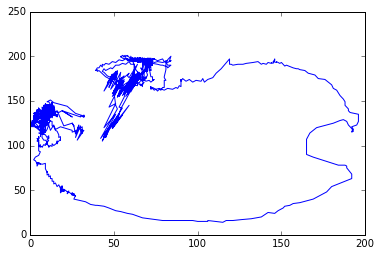

In [48]:
plt.plot(raw_pos[:,1], raw_pos[:,2])

print(raw_pos.shape[0])

[[  91.7   163.     52.  ]
 [  91.7   163.     52.  ]
 [  91.72  173.     54.  ]
 ..., 
 [ 151.68  129.     10.  ]
 [ 151.7   134.     10.  ]
 [ 151.7   129.      9.  ]]


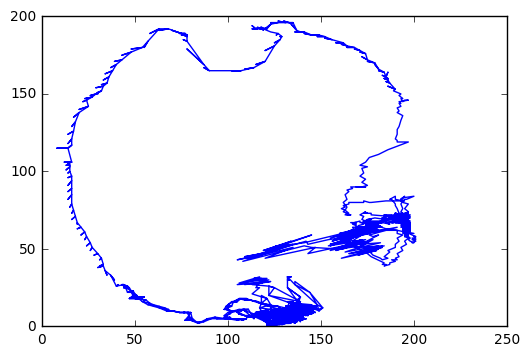

In [16]:
posx, posy, post = get_bin_pos(bin_filename)
#%timeit posx, posy, post = get_bin_pos(bin_filename)
print(np.hstack((post, posx, posy)))

plt.plot(posx, posy)

In [7]:
def get_setfile_parameter(parameter, set_filename):
    
    if not os.path.exists(set_filename):
        return
    
    with open(set_filename, 'r+') as f:
        for line in f:
            if parameter in line:
                if line.split(' ')[0] == parameter:
                    # prevents part of the parameter being in another parameter name
                    return line.split(' ')[-1]

def create_pos(pos_filename, pos_data):
    
    n = int(pos_data.shape[0])
    
    session_path, session_filename = os.path.split(pos_filename)
    tint_basename = os.path.splitext(session_filename)[0]
    set_filename = os.path.join(session_path, '%s.set' % tint_basename)
    
    if os.path.exists(pos_filename):
        return
    
    header = get_set_header(set_filename)
    
    with open(pos_filename, 'wb+') as f:  # opening the .pos file
        write_list = []
        
        write_list.append(header)
        
        header_vals = ['\r\nnum_colours %d' % 4,
                       '\r\nmin_x %d' % 0,
                       '\r\nmax_x %d' % 768,
                       '\r\nmin_y %d' % 0,
                       '\r\nmax_y %d' % 574,
                       '\r\nwindow_min_x %d' % int(get_setfile_parameter('xmax', set_filename)),
                       '\r\nwindow_max_x %d' % int(get_setfile_parameter('ymax', set_filename)),
                       '\r\nwindow_min_y %d' % int(get_setfile_parameter('xmin', set_filename)),
                       '\r\nwindow_max_y %d' % int(get_setfile_parameter('ymin', set_filename)),
                       '\r\ntimebase %d hz' % 50,
                       '\r\nbytes_per_timestamp %d' % 4,
                       '\r\nsample_rate %.1f hz' % 50.0,
                       '\r\nEEG_samples_per_position %d' % 5,
                       '\r\nbearing_colour_1 %d' % 0,
                       '\r\nbearing_colour_2 %d' % 0,
                       '\r\nbearing_colour_3 %d' % 0,
                       '\r\nbearing_colour_4 %d' % 0,
                       '\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2',
                       '\r\nbytes_per_coord %d' % 2,
                       '\r\npixels_per_metre %f' % float(get_setfile_parameter('tracker_pixels_per_metre', set_filename)),
                       '\r\nnum_pos_samples %d' % n,
                       '\r\ndata_start']

        for value in header_vals:
            write_list.append(bytes(value, 'utf-8'))

        onespot = 1  # this is just in case we decide to add other modes.

        # write_list = [bytes(headers, 'utf-8')]

        # write_list.append()
    
        if onespot:
            position_format_string = 'i8h'
            position_format_string = '>%s' % (n * position_format_string)
            write_list.append(struct.pack(position_format_string, pos_data.flatten()))

        write_list.append(bytes('\r\ndata_end\r\n', 'utf-8'))
        f.writelines(write_list)

    

# Reading the Data



In [8]:
def get_lfp_bytes(iterations):
    """This function works, but the strategy I use didn't. I was going to slice the bytearray like you would
    a numpy array but that didn't work"""
    data_byte_len = 384
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*432 + 32
    offset_indices = np.tile(offset_indices,(384,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices
    
def get_lfp_indices(iterations):
    data_byte_len = 192
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*213 + 13
    offset_indices = np.tile(offset_indices,(192,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices

    
def find_n(iterations, optimal=1000):
    n = optimal
    
    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

    
def get_channel_bytes(channel_number, samples):
    """This will get the indices of the data if it is just the lfp data (not the bytes header bytes or trailing bytes)"""
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)


def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode) # just in case the user gave a string as the tetrode
    
    return np.arange(1,5) + 4*(tetrode-1)

def get_bin_data(bin_filename, tetrode):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode that you want to get"""
    #Reading the Data
    
    channels = get_channel_from_tetrode(tetrode)
    
    byte_count = os.path.getsize(bin_filename)
    
    bytes_per_iteration = 432
    
    iteration_count = int(byte_count/bytes_per_iteration)  
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    #DaqFs = 48000
    #duration = iteration_count * 3 / DaqFs
    #duration = np.ceil(duration)
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)
    
    try:
        all_data = np.zeros(total_sample_count)
        tetrode_data = np.zeros((4, channel_sample_count))
        LargeData = False
        all_data = None
        tetrode_data = None
    except MemoryError:
        # Cannot read all the data into memory, do it one iteration at a time
        LargeData = True
        all_data = None
        tetrode_data = np.zeros((4, channel_sample_count))
    
    
    with open(bin_filename, 'rb') as f:
        #open the bin file
        #f.seek(header_byte_len) # moves the current position to the LFP data
        data = np.zeros(total_sample_count)
        
        total_data_bytes = int(64*3*iteration_count)
        print(iteration_count)
        
        # the data is too large to load at once, so just do it one iteration at a time
        print('Performing slower method due to memory error failing to allow loading all the data at once.')
        # attempting to read all data into memory
        for i in range(iteration_count):

            _ = f.read(header_byte_len)

            data_sample = f.read(data_byte_len)
            data_sample = np.asarray(struct.unpack('192h', data_sample))

            tetrode_data[:,np.arange(i,i+4)] = samples_to_array(data_sample, channels=channels.tolist())

            f.seek(bytes_per_iteration, 1) # moving current position to next data portion
            
    return tetrode_data
    

In [10]:
with open(bin_filename, 'rb') as f:
    #open the bin file
    #f.seek(12)
    bytes_per_iteration = 432
    byte_skip = 400 # 384 ephys data bytes + 16 trailer bytes
    
    for i in range(iteration_count):
        byte_id = f.read(4).decode(encoding='UTF-8')
        
        if 'ADU2' in byte_id:
            f.seek(8, 1)  # moves the current position by 10 bytes
            position_data = f.read(20)
            frame_count = position_data[:4]
            print(position_data[4:])
            position_data = np.asarray(struct.unpack('8h', position_data[4:]))
            print(position_data)
            f.seek(byte_skip,1)
            break
            
        else:
            f.seek(bytes_per_iteration-4, 1)
        

NameError: name 'iteration_count' is not defined

In [9]:
def get_bin_data2(bin_filename, tetrode):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode that you want to get"""
    #Reading the Data
    bin_directory = os.path.dirname(bin_filename)
    session = os.path.basename(os.path.splitext(bin_filename)[0])
    set_filename = os.path.join(bin_directory, '%s.set' % session)
    
    # byte_id (4 bytes), packetnumber (4 bytes) = 2i
    # dig in (2), sync in (2) = 2h
    # frame_cnt (4) = i
    # 8 words (2/each), 192 ephys data points (2 each), dig out (2), stim stat(2), 10 bytes of zeros (5x 2 bytes), 2 bytes ascii
    # string = 2i,2h,211i
    iteration_string = '%di%dhi%dh' % (2, 2, 8+192+1+1+5+1) 
    
    channels = get_channel_from_tetrode(tetrode)
    
    byte_count = os.path.getsize(bin_filename)
    
    bytes_per_iteration = 432
    
    iteration_count = int(byte_count/bytes_per_iteration)  
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    #DaqFs = 48000
    #duration = iteration_count * 3 / DaqFs
    #duration = np.ceil(duration)
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)
    
    '''
    try:
        all_data = np.zeros(2*total_sample_count)
        tetrode_data = np.zeros((4, channel_sample_count))
        LargeData = False
        all_data = None
        tetrode_data = None
        
        simul_iterations = iteration_count # number of simultaneous iterations

        n = 1
        byte_chunksize = simul_iterations*bytes_per_iteration
        
    except MemoryError:
        # Cannot read all the data into memory, do it one iteration at a time
        LargeData = True
        all_data = None
        tetrode_data = None
        print("performing a slower method")
        n = find_n(iteration_count, optimal=1000) # finds how many loops to do
        print('Number of loops: %d' % int(n))
        simul_iterations = int(iteration_count / n)
        simul_samples = simul_iterations*3
        byte_chunksize = simul_iterations*bytes_per_iteration
    
    
    gb_per_iteration = 432/(1024**3) # gb / iteration
    gb_to_read = 2
    simul_iterations = int(gb_to_read / gb_per_iteration)
    if simul_iterations > iteration_count:
        simul_iterations = iteration_count
        
    '''
    
    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)
    
    #n = find_n(iteration_count, optimal=1000) # finds how many loops to do
    n = int(iteration_count / simul_iterations)
    print('Number of loops: %d' % int(n))
    print('Simulataneous Iterations: %d' % int(simul_iterations))
    print(iteration_count)
    # simul_iterations = int(iteration_count / n)
    # n = find_n(iteration_count, optimal=1000) # finds how many loops to do
    
    simul_samples = simul_iterations*3
    byte_chunksize = int(simul_iterations*bytes_per_iteration)

    with open(bin_filename, 'rb') as f:
        #open the bin file

        tetrode_data = np.zeros((4, channel_sample_count))
        
        for i in range(n):
            data = f.read(byte_chunksize)
            
            data = np.asarray(struct.unpack('<%s' % (simul_iterations*iteration_string), data))
            # print(data[:100])
            data = data[get_lfp_indices(simul_iterations)]
        
            tetrode_data[:,simul_samples*i:simul_samples*(i+1)] = samples_to_array(data, channels=channels.tolist())
        
    return tetrode_data

In [65]:
data = get_bin_data2(bin_filename, 1)
print('done')

Number of loops: 1
Simulataneous Iterations: 960100
960100
done


In [66]:
print(bin_filename)

C:\Users\Geoffrey Barrett\Desktop\RAW Data\ConvFromOtherDaq\20170829-1-CYLINDEROPENFIELD.bin


In [70]:
print(data[0,:20])

[    0.     0.     0.  8552.  4172. -3080. -3080. -3088. -1022.   786.
   854.  -398. -1042.   140.  2694.  5560.  7360.  6616.  3494.  -126.]


In [10]:
def get_bin_data3(bin_filename, channels=None, tetrode=None):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode or channels (from 1-64) that you want to get"""
    # Reading the Data
    bin_directory = os.path.dirname(bin_filename)
    session = os.path.basename(os.path.splitext(bin_filename)[0])
    set_filename = os.path.join(bin_directory, '%s.set' % session)

    # byte_id (4 bytes), packetnumber (4 bytes) = 2i
    # dig in (2), sync in (2) = 2h
    # frame_cnt (4) = i
    # 8 words (2/each), 192 ephys data points (2 each), dig out (2), stim stat(2), 10 bytes of zeros (5x 2 bytes), 2 bytes ascii
    # string = 2i,2h,211i
    iteration_string = '%di%dhi%dh' % (2, 2, 8 + 192 + 1 + 1 + 5 + 1)

    if tetrode is not None:
        channels = get_channel_from_tetrode(tetrode)
    else:
        channels = np.array(channels)  # just in case it isn't an np.array

    byte_count = os.path.getsize(bin_filename)

    bytes_per_iteration = 432

    iteration_count = int(byte_count / bytes_per_iteration)
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    # DaqFs = 48000
    # duration = iteration_count * 3 / DaqFs
    # duration = np.ceil(duration)

    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)

    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do

    simul_samples = simul_iterations * 3
    byte_chunksize = int(simul_iterations * bytes_per_iteration)

    with open(bin_filename, 'rb') as f:
        # open the bin file

        channel_data = np.zeros((len(channels), channel_sample_count))

        for i in range(n):
            data = f.read(byte_chunksize)
            data = np.asarray(struct.unpack('<%s' % (simul_iterations * iteration_string), data))
            data = data[get_lfp_indices(simul_iterations)]

            channel_data[:, simul_samples * i:simul_samples * (i + 1)] = samples_to_array(data, 
                                                                                          channels=channels.tolist())

    return channel_data

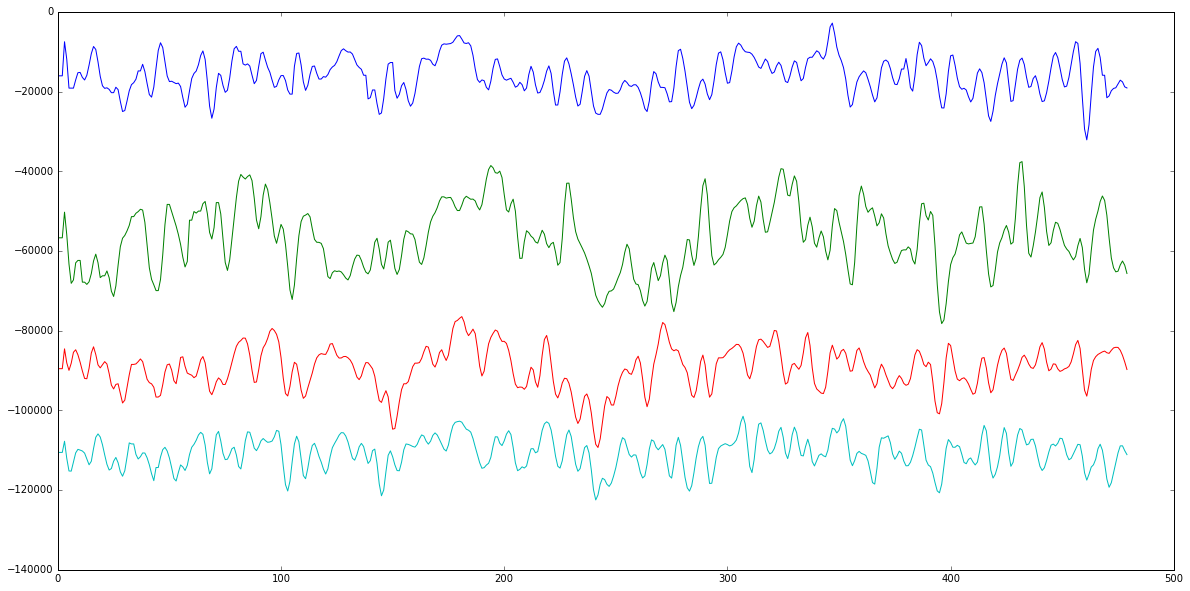

In [68]:
channel_data = data
Fs = 48000
time_value = 10/1000

num_samples = int(Fs*time_value)

indices = np.arange(num_samples)

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
for i, chan_data in enumerate(channel_data):
    chan_data = chan_data[indices]
    if i == 0:
        min_value = np.amin(chan_data)
    else:
        min_value = min_value - (np.amax(chan_data) - np.amin(chan_data))
        
    ax.plot(chan_data + min_value)

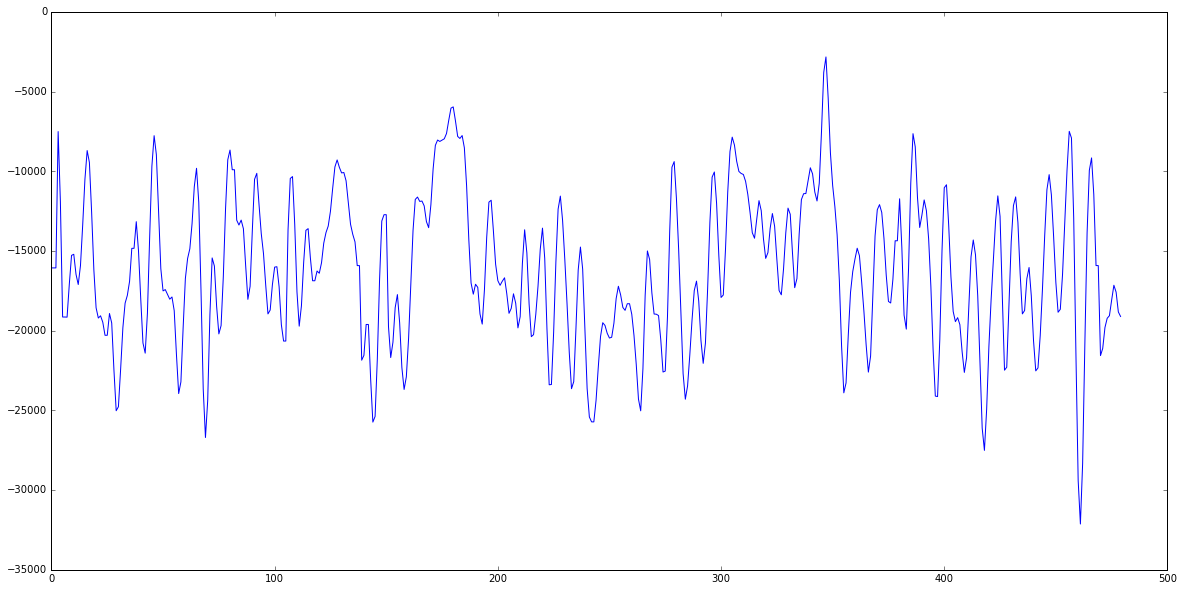

In [49]:
data = get_bin_data3(bin_filename, channels=[1])

channel_data = data
Fs = 48000
time_value = 10/1000

num_samples = int(Fs*time_value)

indices = np.arange(num_samples)

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
for i, chan_data in enumerate(channel_data):
    chan_data = chan_data[indices]
    if i == 0:
        min_value = np.amin(chan_data)
    else:
        min_value = min_value - (np.amax(chan_data) - np.amin(chan_data))
        
    ax.plot(chan_data + min_value)

## Process the Data

In [ ]:
# Notch Filter
notch_filter_settings = 60
data = sp.Filtering().notch_filt(data, Fs, freq=notch_filter_setting, band=10,
                                                     order=3)

In [13]:
def getpos2(pos_fpath, arena, method=''):
    '''getpos function:
    ---------------------------------------------
    variables:
    -pos_fpath: the full path (C:\example\session.pos)

    output:
    t: column numpy array of the time stamps
    x: a column array of the x-values (in pixels)
    y: a column array of the y-values (in pixels)
    '''
    with open(pos_fpath, 'rb+') as f:  # opening the .pos file
        headers = ''  # initializing the header string
        for line in f:  # reads line by line to read the header of the file
            # print(line)
            if 'data_start' in str(line):  # if it reads data_start that means the header has ended
                headers += 'data_start'
                break  # break out of for loop once header has finished
            elif 'duration' in str(line):
                headers += line.decode(encoding='UTF-8')
            elif 'num_pos_samples' in str(line):
                num_pos_samples = int(line.decode(encoding='UTF-8')[len('num_pos_samples '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8')[len('bytes_per_timestamp '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_coord' in str(line):
                bytes_per_coord = int(line.decode(encoding='UTF-8')[len('bytes_per_coord '):])
                headers += line.decode(encoding='UTF-8')
            elif 'timebase' in str(line):
                timebase = (line.decode(encoding='UTF-8')[len('timebase '):]).split(' ')[0]
                headers += line.decode(encoding='UTF-8')
            elif 'pixels_per_metre' in str(line):
                ppm = float(line.decode(encoding='UTF-8')[len('pixels_per_metre '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_x' in str(line) and 'window' not in str(line):
                min_x = int(line.decode(encoding='UTF-8')[len('min_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_x' in str(line) and 'window' not in str(line):
                max_x = int(line.decode(encoding='UTF-8')[len('max_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_y' in str(line) and 'window' not in str(line):
                min_y = int(line.decode(encoding='UTF-8')[len('min_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_y' in str(line) and 'window' not in str(line):
                max_y = int(line.decode(encoding='UTF-8')[len('max_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'pos_format' in str(line):
                headers += line.decode(encoding='UTF-8')
                if 't,x1,y1,x2,y2,numpix1,numpix2' in str(line):
                    two_spot = True
                else:
                    two_spot = False
                    print('The position format is unrecognized!')

            else:
                headers += line.decode(encoding='UTF-8')

    if two_spot:

        bytes_offset = bytes_per_timestamp + 8 * bytes_per_coord  # number of bytes per position set

        '''Run when two spot mode is on, (one_spot has the same format so it will also run here)'''
        with open(pos_fpath, 'rb+') as f:
            '''get_pos for one_spot'''
            pos_data = f.read()  # all the position data values (including header)
            pos_data = pos_data[len(headers):]  # removes the header values

            x = np.zeros((num_pos_samples, 2))  # [x1, x2]
            y = np.zeros((num_pos_samples, 2))  # [y1, y2]
            t = np.zeros((num_pos_samples, 1))  # [t]

            numpix1 = np.zeros((num_pos_samples, 1))  # [numpix1]
            numpix2 = np.zeros((num_pos_samples, 1))  # [numpix2]

            t_start = 0  # the time is the first value
            x1_start = bytes_per_timestamp  # 4, x1 is the second value
            y1_start = bytes_per_timestamp + bytes_per_coord  # 6, y1 is the third value

            x2_start = bytes_per_timestamp + 2 * bytes_per_coord  # 8, x2 is the fourth value
            y2_start = bytes_per_timestamp + 3 * bytes_per_coord  # 10, y2 is the fifth value

            numpix1_start = bytes_per_timestamp + 4 * bytes_per_coord
            numpix2_start = bytes_per_timestamp + 5 * bytes_per_coord
            
            z = 0
            
            for sample in range(0, num_pos_samples):
                '''struct outputs a tuple so make sure you take the 0th index to make it just a number'''
                # used np.asarray to convert from tuple (the output from struct.unpack, to a np.array)
                byte_values = pos_data[t_start+4 + sample * bytes_offset:t_start + sample * bytes_offset+ 20]
                #print(byte_values)
                
                z +=1
                
                if z > 4:
                    pass
                    #break
    
                
                t[sample] = np.asarray(struct.unpack('>i',
                                                     pos_data[t_start +
                                                              sample * bytes_offset:bytes_per_timestamp +
                                                                                    sample * bytes_offset])[0])
                
                
                # each sample is 20 bytes long, 1 4-byte frame count, and 8 2-byte words

                x[sample] = np.asarray(struct.unpack('>2h',
                                                     pos_data[x1_start +
                                                              sample * bytes_offset:(x1_start + bytes_per_coord) +
                                                                                    sample * bytes_offset] +
                                                     pos_data[x2_start + sample * bytes_offset:(x2_start +
                                                                                                bytes_per_coord) +
                                                                                               sample * bytes_offset]),
                                       dtype=tuple)

                y[sample] = np.asarray(
                    struct.unpack('>2h',
                                  pos_data[y1_start +
                                           sample * bytes_offset:(y1_start + bytes_per_coord) +
                                                                 sample * bytes_offset] +
                                  pos_data[y2_start + sample * bytes_offset:(y2_start + bytes_per_coord) +
                                                                            sample * bytes_offset]), dtype=tuple)

                numpix1[sample] = np.asarray(
                    struct.unpack('>h', pos_data[numpix1_start +
                                                 sample * bytes_offset:(numpix1_start +
                                                                        bytes_per_coord) + sample * bytes_offset])[0])

                numpix2[sample] = np.asarray(
                    struct.unpack('>h', pos_data[numpix2_start +
                                                 sample * bytes_offset:(numpix2_start +
                                                                        bytes_per_coord) + sample * bytes_offset])[0])

        if method == 'raw':
            return x[:, 0].reshape((len(x), 1)), y[:, 0].reshape((len(y), 1)), t[:, 0].reshape((len(t), 1))

        t = t * (1 / int(timebase))  # converting the frame number from Axona to the time value

        # values that are NaN are set to 1023 in Axona's system, replace these values by NaN's

        for sample in range(0, len(t)):
            for x_index in range(len(x[sample])):  # replace the 1023 values with nan's
                if x[sample][x_index] == 1023:
                    x[sample][x_index] = np.nan

            for y_index in range(len(y[sample])):  # replace the 1023 values with nan's
                if y[sample][y_index] == 1023:
                    y[sample][y_index] = np.nan

            if numpix1[sample] == 1023:  # replace the 1023 values with nan's
                numpix1[sample] = np.nan

            if numpix2[sample] == 1023:  # replace the 1023 values with nan's
                numpix2[sample] = np.nan

                # print('Time: ' + str(t[sample]) + ', X: ' + str(x[sample]) + ', Y: ' + str(y[sample]) + ', np1: ' + str(numpix1[sample]) + ', np2: ' + str(numpix2[sample]))

        # checks for the column of Nans and chooses the column (most likely the first column)
        if np.nansum(x[:, 0]) > np.nansum(x[:, 1]):
            '''the first column doesnt have the nans, set the values of x and y to the first column'''
            x = x[:, 0]
            y = y[:, 0]
        else:
            x = x[:, 1]
            y = y[:, 1]

        didFix, fixedPost = fixTimestamps(t)

        if didFix:
            t = fixedPost

        x, y = arena_config(x, y, arena, conversion=ppm, center=np.asarray([np.mean([min_x, max_x]),
                                                                            np.mean([min_y,max_y])]))

        # remove any NaNs at the end of the file
        x, y, t = removeNan(x, y, t)


    else:
        print("Haven't made any code for this part yet.")

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1))


In [14]:
def new_get_pos(pos_fpath, arena, method=''):
    '''getpos function:
    ---------------------------------------------
    variables:
    -pos_fpath: the full path (C:\example\session.pos)

    output:
    t: column numpy array of the time stamps
    x: a column array of the x-values (in pixels)
    y: a column array of the y-values (in pixels)
    '''
    
    with open(pos_fpath, 'rb+') as f:  # opening the .pos file
        headers = ''  # initializing the header string
        for line in f:  # reads line by line to read the header of the file
            # print(line)
            if 'data_start' in str(line):  # if it reads data_start that means the header has ended
                headers += 'data_start'
                break  # break out of for loop once header has finished
            elif 'duration' in str(line):
                headers += line.decode(encoding='UTF-8')
            elif 'num_pos_samples' in str(line):
                num_pos_samples = int(line.decode(encoding='UTF-8')[len('num_pos_samples '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8')[len('bytes_per_timestamp '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_coord' in str(line):
                bytes_per_coord = int(line.decode(encoding='UTF-8')[len('bytes_per_coord '):])
                headers += line.decode(encoding='UTF-8')
            elif 'timebase' in str(line):
                timebase = (line.decode(encoding='UTF-8')[len('timebase '):]).split(' ')[0]
                headers += line.decode(encoding='UTF-8')
            elif 'pixels_per_metre' in str(line):
                ppm = float(line.decode(encoding='UTF-8')[len('pixels_per_metre '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_x' in str(line) and 'window' not in str(line):
                min_x = int(line.decode(encoding='UTF-8')[len('min_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_x' in str(line) and 'window' not in str(line):
                max_x = int(line.decode(encoding='UTF-8')[len('max_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_y' in str(line) and 'window' not in str(line):
                min_y = int(line.decode(encoding='UTF-8')[len('min_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_y' in str(line) and 'window' not in str(line):
                max_y = int(line.decode(encoding='UTF-8')[len('max_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'pos_format' in str(line):
                headers += line.decode(encoding='UTF-8')
                if 't,x1,y1,x2,y2,numpix1,numpix2' in str(line):
                    two_spot = True
                else:
                    two_spot = False
                    print('The position format is unrecognized!')

            else:
                headers += line.decode(encoding='UTF-8')

    if two_spot:
        
        bytes_offset = bytes_per_timestamp + 8 * bytes_per_coord  # number of bytes per position set

        '''Run when two spot mode is on, (one_spot has the same format so it will also run here)'''
        with open(pos_fpath, 'rb+') as f:
            '''get_pos for one_spot'''
            pos_data = f.read()  # all the position data values (including header)
            pos_data = pos_data[len(headers):-12]  # removes the header values
            
            byte_string = 'i8h'
            
            pos_data = np.asarray(struct.unpack('>%s' % (num_pos_samples*byte_string), pos_data))
            pos_data = pos_data.astype(float).reshape((num_pos_samples,9))  # there are 8 words and 1 time sample
        
        x = pos_data[:,1]
        y = pos_data[:,2]
        t = pos_data[:,0]
        
        x = x.reshape((len(x), 1)) 
        y = y.reshape((len(y), 1))
        t = t.reshape((len(t), 1))
      
        df.to_csv("converted_position_data.txt", sep='\t', index=False, index_label=False)
        
        if method == 'raw':
            return x, y, t
        
        t = np.divide(t, np.float(50))  # converting the frame number from Axona to the time value

        # values that are NaN are set to 1023 in Axona's system, replace these values by NaN's

        x[np.where(x==1023)] = np.nan
        y[np.where(y == 1023)] = np.nan
        
        didFix, fixedPost = fixTimestamps(t)

        if didFix:
            t = fixedPost

        x, y = arena_config(x, y, arena, conversion=ppm, center=np.asarray([np.mean([min_x, max_x]),
                                                                            np.mean([min_y,max_y])]))

        # remove any NaNs at the end of the file
        x, y, t = removeNan(x, y, t)


    else:
        print("Haven't made any code for this part yet.")

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1))


(3050, 3)
(3050, 3)


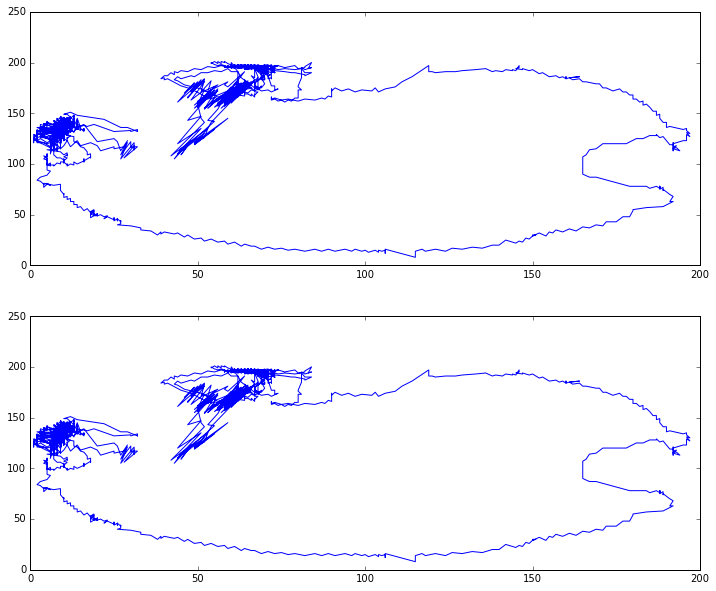

In [98]:
#pos_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq\\daqoutput\\20170829-1-CYLINDEROPENFIELD-converted.pos'
pos_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD-converted.pos'
pos_filename2 = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.pos'
#x, y, t = new_get_pos(pos_filename, 'BehaviorRoom')
#print(np.hstack((t, x, y)))
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
x, y, t = getpos2(pos_filename, 'BehaviorRoom', method='raw')
print(np.hstack((t, x, y)).shape)
axs[0].plot(x,y)

x2, y2, t2 = getpos2(pos_filename2, 'BehaviorRoom', method='raw')
print(np.hstack((t2, x2, y2)).shape)
axs[1].plot(x2,y2)

In [40]:
print(pos_fpath)
posx, posy, post = getpos2(pos_filename, 'BehaviorRoom', method='raw')


NameError: name 'pos_fpath' is not defined

In [15]:
spikes = {}
spikes[1.0] = np.array([[1,2,3,4,51], [1,2,3,4,51]])
spikes[2.0] = np.array([[1,2,3,4,521], [1,2,3,4,51]])
spikes[1.3] = np.array([[1,2,3,4,531], [1,2,3,4,51]])
spikes[3.10] = np.array([[1,2,3,4,541], [1,2,3,4,51]])

keys = np.asarray(sorted(spikes.keys()))
print(keys)
keys = np.repeat(keys, 2)
print(keys)

values = np.asarray([value for (key, value) in sorted(spikes.items())])
print(values.shape)
values = values.reshape((4*2, 5))
print(values.shape)

new_array = np.hstack((keys.reshape(len(keys),1), values))
print(new_array)

[ 1.   1.3  2.   3.1]
[ 1.   1.   1.3  1.3  2.   2.   3.1  3.1]
(4, 2, 5)
(8, 5)
[[   1.     1.     2.     3.     4.    51. ]
 [   1.     1.     2.     3.     4.    51. ]
 [   1.3    1.     2.     3.     4.   531. ]
 [   1.3    1.     2.     3.     4.    51. ]
 [   2.     1.     2.     3.     4.   521. ]
 [   2.     1.     2.     3.     4.    51. ]
 [   3.1    1.     2.     3.     4.   541. ]
 [   3.1    1.     2.     3.     4.    51. ]]


In [34]:
from struct import *
import re
a = pack('>b <b >b', 1, 2, 3)
print(a)
print(list(a))
b = [a[i:i + 1] for i in range(0, len(a), 1)]
print(b)

error: bad char in struct format

In [35]:
with open('test.txt', 'w') as f:
    
    write_order = ['hello', 'howareyou']
    
    f.writelines(write_order)
    

In [36]:
np.arange(1, 5) + 4 * (1 - 1)

array([1, 2, 3, 4])

In [20]:
a = np.array([1,2,3,4,5,5])
print(a.shape)

a = np.tile(a, (4,1))
print(a)
print(a.shape)

a = a.flatten(order='F')
print(a)

(6,)
[[1 2 3 4 5 5]
 [1 2 3 4 5 5]
 [1 2 3 4 5 5]
 [1 2 3 4 5 5]]
(4, 6)
[1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 5 5 5 5]


In [31]:
a = np.array([1,2,3])
a.shape

print(np.divide(2000, a*100))

[ 20.          10.           6.66666667]


In [44]:
a = np.array([[1,2,3], [4,5,6], [5,6,6]])
print(a)

print(np.multiply(a, np.tile(np.array([1,2,3]).reshape((3,1)), 3)))

[[1 2 3]
 [4 5 6]
 [5 6 6]]
[[ 1  2  3]
 [ 8 10 12]
 [15 18 18]]


In [43]:
print(np.tile(np.array([1,2,3]).reshape((3,1)), 3))

[[1 1 1]
 [2 2 2]
 [3 3 3]]
